In [1]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pycmap
import seaborn as sns
from tlviz.factor_tools import factor_match_score
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp
    

In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

bi_hexes = [neutral_color, '#7222D3']
# bi_hexes = [neutral_color, line_color]
bi_cmap = get_continuous_cmap(bi_hexes)


In [4]:
# helper functions

def unique_bins(array, n_bins, bounds=None, reverse=False):
    '''This is a function that maps an array of continuous values with potential duplicates to 
    a set of bins in such a way that each of the original continuous values is mapped to a unique bin, and the
    distribution of binned values approximates the distribution of continuous values as closely as possible.
    
    My quick and dirty approach to this problem sorts the input array into the appropriate number of bins. Then,
    starting in the middle and alternating outward left and right, the algorithm checks to see if each bin has 
    more than one resident. If so, it will again alternate outward left and right from that position and allocate
    the extra residents to the nearest free bins.
    
    Parameters
    ----------
    array : np.array
        Sorted array of values to be placed into bins.
    n_bins : int
        Number of bins to use.
    bounds : (float, float)
        Upper and lower bounds to use for bin-mapping.
    reverse : bool
        Optional flag to reverse the index ordering of the output.
    
        
    Returns
    -------
    index : np.array
        Indices indicating mapping of input values to bins, where index[i] indicates the index of the bin 
        mapping of input value array[i] (assuming input array is sorted).
    '''
    # check number of bins
    if not n_bins >= len(array):
        raise ValueError('The number of bins must be >= len(array).')
    # add bounds if supplied
    if bounds is not None:
        array = np.concatenate((array, bounds))
    # make histogram
    counts, _ = np.histogram(array, bins=n_bins)
    # remove bounds if added
    if bounds is not None:
        counts[0] -= 1
        counts[-1] -= 1
    # start from the middle
    i = int(n_bins/2)
    for j in range(n_bins):
        # alternate left and right
        if j % 2:
            i -= j
        else:
            i += j
        # resolve collisions
        if counts[i] > 1:
            # set new counter for exploring nearby positions
            k = i
            for l in range(2*n_bins):
                # alternate left and right
                if l % 2:
                    k -= l
                else:
                    k += l
                # check if we're still in range
                if 0 <= k < n_bins:
                    # check for an empty spot
                    if counts[k] == 0:
                        counts[k] = 1
                        counts[i] -= 1
                        # check if all collisions have been resolved yet
                        if counts[i] == 1:
                            break
    # select indices of non-zero values
    index = np.where(counts == 1)[0]
    # reverse if requested
    if reverse:
        index = (n_bins - 1) - index
    return index


# import data
### cluster data

In [5]:
# read in aligned model datasets

datapath = Path('../../data/')
outdir = Path('../../figures/7-interpretation/')

pro_ds = xr.open_dataset(datapath / '5-models/pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / '5-models/syn-aligned-models.nc')

fe_clusters = {'pro': 7, 'syn': 8}
n_clusters = {'pro': 15, 'syn': 12}

pro_ds


<xarray.Dataset>
Dimensions:          (Bootstrap: 100, Replicate: 3, Component: 15,
                      Ortholog: 5023, Clade: 3, SampleName: 74)
Coordinates:
  * Bootstrap        (Bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * Replicate        (Replicate) object 'A' 'B' 'C'
  * Component        (Component) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * Ortholog         (Ortholog) int64 60000001 60000002 ... 60040287 60040292
  * Clade            (Clade) object 'HLI' 'HLII' 'LLI'
  * SampleName       (SampleName) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.NS...
Data variables:
    ComponentWeight  (Bootstrap, Replicate, Component) float64 ...
    GeneWeight       (Bootstrap, Replicate, Component, Ortholog) float64 ...
    TaxonWeight      (Bootstrap, Replicate, Component, Clade) float64 ...
    SampleWeight     (Bootstrap, Replicate, Component, SampleName) float64 ...
    Sample           (Bootstrap, Replicate, SampleName) object ...
    Annotation       (Ortholog) object ...
Attributes:
    Rank:               15
    Lambda:             15.0
    AlignRefBootstrap:  66
    AlignRefReplicate:  B

In [6]:
# read in metadata

sample_df = pd.read_csv(datapath / 'metadata/sample_metadata_merged.csv')
sample_df['Datetime'] = pd.to_datetime(sample_df['Datetime'], format='%m/%d/%y %H:%M')

sample_df


,SampleName,Cruise,Year,Datetime,Latitude,Longitude,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Experiment,Condition,Treatment,Timepoint
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,2017-06-06 06:56:00,36.999833,-158.000,50,Gradients 2 DCM,depth profiles,0.29,6am,NaN,NaN,NaN,NaN
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,2017-06-09 05:30:00,34.000167,-158.000,56,Gradients 2 DCM,depth profiles,0.23,6am,NaN,NaN,NaN,NaN
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,2017-06-10 09:34:00,32.000167,-158.000,87,Gradients 2 DCM,depth profiles,0.40,10am,NaN,NaN,NaN,NaN
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,2017-06-11 05:50:00,29.582000,-158.002,95,Gradients 2 DCM,depth profiles,0.24,6am,NaN,NaN,NaN,NaN
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,2019-04-16 08:00:00,41.670000,-158.050,75,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,G3.DEPTH.NS.S6C7.15m,Gradients 3,2019,2019-04-22 06:44:00,32.920000,-158.000,15,Gradients 3 depth profile,surface transect,0.28,6am,NaN,NaN,NaN,NaN
83,G3.UW.NS.UW40_1.7m,Gradients 3,2019,2019-04-24 05:57:00,40.880000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
84,G3.DEPTH.NS.S8C2.15m,Gradients 3,2019,2019-04-24 14:47:00,42.330000,-158.000,15,Gradients 3 depth profile,surface transect,0.62,2pm,NaN,NaN,NaN,NaN
85,G3.UW.NS.UW40_2.7m,Gradients 3,2019,2019-04-25 06:01:00,40.090000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


In [7]:
# pull out clusters hypothesized to relate to iron limitation

pro_fe_df = pro_ds.sel(Component=fe_clusters['pro']).SampleWeight.to_series().reset_index()
pro_fe_df['Genus'] = 'Prochlorococcus'
syn_fe_df = syn_ds.sel(Component=fe_clusters['syn']).SampleWeight.to_series().reset_index()
syn_fe_df['Genus'] = 'Synechococcus'

fe_cluster_df = pd.concat([pro_fe_df, syn_fe_df]).reset_index(drop=True)
fe_cluster_df = pd.merge(fe_cluster_df, sample_df, on='SampleName', how='left')

fe_cluster_df


,Bootstrap,Replicate,SampleName,SampleWeight,Genus,Cruise,Year,Datetime,Latitude,Longitude,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Experiment,Condition,Treatment,Timepoint
0,0,A,G1.SURF.NS.S02C1.15m,0.000000,Prochlorococcus,Gradients 1,2016,2016-04-20 05:51:00,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
1,0,A,G1.SURF.NS.S04C1.15m,0.000000,Prochlorococcus,Gradients 1,2016,2016-04-22 05:40:00,28.143167,-158.000667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
2,0,A,G1.SURF.NS.S06C1.15m,NaN,Prochlorococcus,Gradients 1,2016,2016-04-24 05:37:00,32.583500,-158.001667,15,Gradients 1 surface,surface transect,0.23,6am,NaN,NaN,NaN,NaN
3,0,A,G1.SURF.NS.S08C1.15m,0.000000,Prochlorococcus,Gradients 1,2016,2016-04-26 05:43:00,37.301167,-158.001667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
4,0,A,G1.SURF.NS.S09C1.15m,0.220891,Prochlorococcus,Gradients 1,2016,2016-04-27 05:41:00,36.570000,-158.003167,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48295,99,C,G3.UW.NS.UW35_2.7m,0.066554,Synechococcus,Gradients 3,2019,2019-04-26 05:55:00,35.830000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
48296,99,C,G3.UW.NS.UW37_1.7m,0.070168,Synechococcus,Gradients 3,2019,2019-04-20 06:12:00,37.000000,-158.000000,7,Gradients 3 underway,surface transect,0.26,6am,NaN,NaN,NaN,NaN
48297,99,C,G3.UW.NS.UW38_1.7m,0.155588,Synechococcus,Gradients 3,2019,2019-04-15 05:37:00,38.970000,-158.000000,7,Gradients 3 underway,surface transect,0.23,6am,NaN,NaN,NaN,NaN
48298,99,C,G3.UW.NS.UW40_1.7m,0.143276,Synechococcus,Gradients 3,2019,2019-04-24 05:57:00,40.880000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


In [8]:
# pull out clusters hypothesized to relate to nitrogen limitation

pro_n_df = pro_ds.sel(Component=n_clusters['pro']).SampleWeight.to_series().reset_index()
pro_n_df['Genus'] = 'Prochlorococcus'
syn_n_df = syn_ds.sel(Component=n_clusters['syn']).SampleWeight.to_series().reset_index()
syn_n_df['Genus'] = 'Synechococcus'

n_cluster_df = pd.concat([pro_n_df, syn_n_df]).reset_index(drop=True)
n_cluster_df = pd.merge(n_cluster_df, sample_df, on='SampleName', how='left')

n_cluster_df

,Bootstrap,Replicate,SampleName,SampleWeight,Genus,Cruise,Year,Datetime,Latitude,Longitude,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Experiment,Condition,Treatment,Timepoint
0,0,A,G1.SURF.NS.S02C1.15m,0.020805,Prochlorococcus,Gradients 1,2016,2016-04-20 05:51:00,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
1,0,A,G1.SURF.NS.S04C1.15m,0.247697,Prochlorococcus,Gradients 1,2016,2016-04-22 05:40:00,28.143167,-158.000667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
2,0,A,G1.SURF.NS.S06C1.15m,NaN,Prochlorococcus,Gradients 1,2016,2016-04-24 05:37:00,32.583500,-158.001667,15,Gradients 1 surface,surface transect,0.23,6am,NaN,NaN,NaN,NaN
3,0,A,G1.SURF.NS.S08C1.15m,0.132096,Prochlorococcus,Gradients 1,2016,2016-04-26 05:43:00,37.301167,-158.001667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
4,0,A,G1.SURF.NS.S09C1.15m,0.101922,Prochlorococcus,Gradients 1,2016,2016-04-27 05:41:00,36.570000,-158.003167,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48295,99,C,G3.UW.NS.UW35_2.7m,0.046996,Synechococcus,Gradients 3,2019,2019-04-26 05:55:00,35.830000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
48296,99,C,G3.UW.NS.UW37_1.7m,0.114886,Synechococcus,Gradients 3,2019,2019-04-20 06:12:00,37.000000,-158.000000,7,Gradients 3 underway,surface transect,0.26,6am,NaN,NaN,NaN,NaN
48297,99,C,G3.UW.NS.UW38_1.7m,0.000000,Synechococcus,Gradients 3,2019,2019-04-15 05:37:00,38.970000,-158.000000,7,Gradients 3 underway,surface transect,0.23,6am,NaN,NaN,NaN,NaN
48298,99,C,G3.UW.NS.UW40_1.7m,0.000000,Synechococcus,Gradients 3,2019,2019-04-24 05:57:00,40.880000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


In [15]:
# read in gene annotations

gene_names_df = pd.read_excel(
    datapath / '7-interpretation/fe-n-cluster-annotations.xlsx', 
    sheet_name='Fe-N-CyCOGs', 
    usecols=['Ortholog', 'Gene Name(s)', 'Protein Name(s)']
).rename(columns={'Gene Name(s)': 'GeneLabel', 'Protein Name(s)': 'ProteinLabel'})

gene_names_df


,Ortholog,GeneLabel,ProteinLabel
0,60001290,fbaB,Fba1
1,60001112,isiB,NaN
2,60000706,idiA,FutA
3,60000023,isiA,Pcb
4,60000134,"σ factor, PMM1629",NaN
...,...,...,...
67,60007639,tauA,NaN
68,60000720,nrdJ,NaN
69,60001466,NaN,NaN
70,60004304,NaN,NaN


# import data
### environmental data

In [10]:
# define salinity and chlorophyll fronts

# source: Juranek et al., 2020 https://doi.org/10.1029/2020GB006702
sal_fronts = {2016: 32.15, 2017: 32.5, 2019: 32.34}
chl_fronts = {2016: 33, 2017: 36.2, 2019: 35}


In [11]:
# import data from cmap

api = pycmap.API(token='55bd80f9-8d5d-4c8f-8917-f5b0e924ed45')
api.search_catalog('iron John gradients')


,Variable,Table_Name,Long_Name,Unit,Make,Sensor,Process_Level,Study_Domain,Temporal_Resolution,Spatial_Resolution,...,Data_Source,Distributor,Dataset_Description,Acknowledgement,Dataset_ID,ID,Visualize,Keywords,Unstructured_Dataset_Metadata,Unstructured_Variable_Metadata
0,Fe_dissolved,tblKM1906_Gradients3_Diss_Trace_Metal_Profile,Dissolved Iron Concentrations,nmol/L,Observation,ICP-MS,Reprocessed,Chemistry,Irregular,Irregular,...,"John Lab, University of Southern California","John Lab, University of Southern California",Samples were collected in the North Pacific on...,Sample collection and analysis was supported b...,522,10691,1,"biogeochemistry, chemistry, cruise, Dissolved ...",NaN,NaN
1,Fe_dissolved,tblKOK1606_Gradients1_Diss_Trace_Metal_Profile,Dissolved Iron Concentrations,nmol/L,Observation,ICP-MS,Reprocessed,Chemistry,Irregular,Irregular,...,"John Lab, University of Southern California","John Lab, University of Southern California",Samples were collected in the North Pacific on...,Sample collection and analysis was supported b...,548,11060,1,"biogeochemistry, chemistry, cruise, Dissolved ...",NaN,NaN
2,Fe,tblMGL1704_Gradients2_Trace_Metals,Dissolved Iron Concentrations,nM,Observation,Towfish,Reprocessed,Chemistry+Biogeochemistry,Irregular,Irregular,...,John Lab USC,John Lab - USC,Samples were collected in the North Pacific on...,John Lab - USC,575,11510,1,"biogeochemistry, chemistry, cruise, dissolved ...",NaN,NaN
3,Fe_dissolved,tblMGL1704_Gradients2_Diss_Trace_Metal_Profile,Dissolved Iron Concentrations,nmol/L,Observation,ICP-MS,Reprocessed,Chemistry,Irregular,Irregular,...,"John Lab, University of Southern California","John Lab, University of Southern California",Samples were collected in the North Pacific on...,Sample collection and analysis was supported b...,547,11054,1,"biogeochemistry, chemistry, cruise, Dissolved ...",NaN,NaN
4,Fe_dissolved,tblMGL1704_Gradients2_Diss_Trace_Metal_Surface,Dissolved Iron Concentrations,nmol/L,Observation,ICP-MS,Reprocessed,Chemistry,Irregular,Irregular,...,"John Lab, University of Southern California","John Lab, University of Southern California",Samples were collected in the North Pacific on...,Sample collection and analysis was supported b...,546,11048,1,"biogeochemistry, chemistry, cruise, Dissolved ...",NaN,NaN


In [12]:
# import all iron data from G1, G2, G3

fe_df = pd.concat([
    api.get_dataset('tblKOK1606_Gradients1_Diss_Trace_Metal_Profile'), 
    api.get_dataset('tblMGL1704_Gradients2_Diss_Trace_Metal_Profile'), 
    api.get_dataset('tblMGL1704_Gradients2_Diss_Trace_Metal_Surface'), 
    api.get_dataset('tblKM1906_Gradients3_Diss_Trace_Metal_Profile')
]).reset_index(drop=True)
fe_df['year'] = pd.to_datetime(fe_df['time']).dt.year

fe_df

,time,lat,lon,depth,Cd_dissolved,Pb_dissolved,Fe_dissolved,Ni_dissolved,Cu_dissolved,Zn_dissolved,Mn_dissolved,Co_dissolved,year
0,2016-04-20T08:00:00,23.500000,-158.00000,15.0,0.000000,42.387016,0.133943,2.112766,0.520765,0.406267,0.978415,2.886313,2016
1,2016-04-20T08:00:00,23.500000,-158.00000,45.0,0.000000,40.404233,0.112573,2.144578,0.487953,0.041618,0.956071,1.607434,2016
2,2016-04-20T08:00:00,23.500000,-158.00000,130.0,2.619439,38.345184,0.148592,2.123560,0.530634,0.376382,0.616861,5.833796,2016
3,2016-04-20T08:00:00,23.500000,-158.00000,150.0,9.897086,40.218990,0.397744,2.192099,0.562793,0.346099,0.508902,5.351234,2016
4,2016-04-20T08:00:00,23.500000,-158.00000,200.0,56.298971,70.479227,0.402671,2.449607,0.689346,0.183127,0.334094,11.862347,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2019-04-24T00:00:00,42.333888,-158.00595,75.0,0.156920,0.051880,0.423880,3.489863,1.107804,0.624393,0.859485,0.016049,2019
357,2019-04-24T00:00:00,42.333888,-158.00595,100.0,0.208297,0.069508,1.140576,3.679030,1.401452,2.271989,0.795996,0.021737,2019
358,2019-04-24T00:00:00,42.333888,-158.00595,200.0,0.436411,0.078711,1.454341,4.160885,1.469514,3.321238,0.484288,0.027267,2019
359,2019-04-24T00:00:00,42.333888,-158.00595,300.0,0.581454,0.082272,1.584558,4.917585,1.768565,4.342330,0.446200,0.029886,2019


In [13]:
# import nitrogen data from G1, G2, G3

# dissolved nitrate+nitrite (Karl lab)
n_df =  pd.concat([
    api.get_dataset('tblKOK1606_Gradients1_Nutrients'), 
    api.get_dataset('tblMGL1704_Gradients2_Nutrients'), 
    api.get_dataset('tblKM1906_Gradients3_Organic_Inorganic_Nutrients').rename(columns={'NO3_plus_NO2': 'NO3_NO2'})
]).reset_index(drop=True)
n_df['year'] = pd.to_datetime(n_df['time']).dt.year

# drop any rows that don't have nitrate+nitrite values
n_df = n_df[n_df['NO3_NO2'].notna()]

n_df


,time,lat,lon,depth,Station,Cast,RosPos,SiO4,NO3_NO2,PO4,TOC,NH4,TN,TON,TP,T_OP,NO2,year
10,2016-04-21T19:48:18,23.596333,-157.955333,198.547506,2 ...,3.0,1.0,4.841292,5.022449,0.406518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
11,2016-04-21T19:52:03,23.596333,-157.955333,149.214103,2 ...,3.0,3.0,2.714948,2.159658,0.215674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
12,2016-04-21T19:52:21,23.596333,-157.955333,149.382903,2 ...,3.0,4.0,2.681088,2.214343,0.210792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
13,2016-04-21T19:55:05,23.596333,-157.955333,110.098362,2 ...,3.0,5.0,1.818020,0.578094,0.106029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
14,2016-04-21T19:58:09,23.596333,-157.955333,75.107340,2 ...,3.0,8.0,1.269541,0.000000,0.042003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,2019-04-27T06:04:59,33.230865,-157.998872,7.000000,Underway56,NaN,NaN,NaN,0.009382,0.044702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
428,2019-04-27T08:50:11,32.721290,-157.999772,7.000000,Underway57,NaN,NaN,NaN,0.006008,0.040763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
429,2019-04-27T11:55:46,32.161412,-157.999878,7.000000,Underway58,NaN,NaN,NaN,0.012590,0.025703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
430,2019-04-27T15:22:00,31.537025,-157.993222,7.000000,Underway59,NaN,NaN,3.072060,0.013660,0.061354,59.815844,0.016635,4.149282,4.135623,0.212595,0.151241,0.004416,2019


In [14]:
# merge Fe data on dissolved N data

# only select surface and depth samples for joining
source_df = n_df[n_df.depth.le(15)].reset_index(drop=True)
source_cols = source_df.columns.to_list()
tolerances = [2, 0.25, 0.25, 15] # time, lat, lon, depth

# define target datasets
targets = {
    # dissolved Fe
    'tblKOK1606_Gradients1_Diss_Trace_Metal_Profile': {
        'variables': ['Fe_dissolved'], 
        'tolerances': tolerances
    },
    'tblMGL1704_Gradients2_Diss_Trace_Metal_Profile': {
        'variables': ['Fe_dissolved'], 
        'tolerances': tolerances
    },
    'tblMGL1704_Gradients2_Diss_Trace_Metal_Surface': {
        'variables': ['Fe_dissolved'], 
        'tolerances': tolerances
    },
    'tblKM1906_Gradients3_Diss_Trace_Metal_Profile': {
        'variables': ['Fe_dissolved'], 
        'tolerances': tolerances
    }
}

# join target data on the source dataframe
merged_df = pycmap.Sample(
    source=source_df, 
    targets=targets, 
    replaceWithMonthlyClimatolog=False
)

# merge all of the iron data into one column
fe_start = 'CMAP_Fe_dissolved_tblKOK1606_Gradients1_Diss_Trace_Metal_Profile'
fe_end = 'CMAP_Fe_dissolved_tblKM1906_Gradients3_Diss_Trace_Metal_Profile'
merged_df['Fe_dissolved'] = merged_df.loc[:, fe_start:fe_end].max(axis=1)

# trim the dataframe
merged_df = merged_df[source_cols + ['Fe_dissolved']]

# calculate ratio
merged_df['N:Fe'] = (merged_df['NO3_NO2'] * 1e-6) / (merged_df['Fe_dissolved'] * 1e-9)

merged_df


Gathering metadata .... 
Sampling starts
Sampling finished                                                                                                    

,time,lat,lon,depth,Station,Cast,RosPos,SiO4,NO3_NO2,PO4,TOC,NH4,TN,TON,TP,T_OP,NO2,year,Fe_dissolved,N:Fe
0,2016-04-21T20:09:35,23.596333,-157.955333,5.544578,2 ...,3.0,23.0,1.257459,0.001400,0.051425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,0.133943,10.451338
1,2016-04-23T23:19:38,28.141000,-158.001167,4.897102,4 ...,4.0,24.0,2.130968,0.001132,0.044776,66.000000,NaN,NaN,NaN,NaN,NaN,NaN,2016,0.309918,3.654173
2,2016-04-25T09:42:08,34.052333,-158.002833,14.475400,7 ...,1.0,13.0,5.418142,2.322685,0.218875,NaN,0.207857,NaN,NaN,NaN,NaN,NaN,2016,0.070247,33064.355417
3,2016-04-25T22:59:35,32.676000,-157.994667,4.498135,6 ...,4.0,24.0,3.431834,0.002883,0.067545,62.800000,NaN,NaN,NaN,NaN,NaN,NaN,2016,0.416400,6.924352
4,2016-04-26T09:51:38,37.301167,-158.001667,14.778970,8 ...,1.0,20.0,9.156541,5.874717,0.484636,NaN,0.186932,NaN,NaN,NaN,NaN,NaN,2016,0.135138,43471.890135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2019-04-27T06:04:59,33.230865,-157.998872,7.000000,Underway56,NaN,NaN,NaN,0.009382,0.044702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaN,NaN
95,2019-04-27T08:50:11,32.721290,-157.999772,7.000000,Underway57,NaN,NaN,NaN,0.006008,0.040763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaN,NaN
96,2019-04-27T11:55:46,32.161412,-157.999878,7.000000,Underway58,NaN,NaN,NaN,0.012590,0.025703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaN,NaN
97,2019-04-27T15:22:00,31.537025,-157.993222,7.000000,Underway59,NaN,NaN,3.072060,0.013660,0.061354,59.815844,0.016635,4.149282,4.135623,0.212595,0.151241,0.004416,2019,NaN,NaN


# generate plots
### panel a: ecotype weights
### panel b: gene weights

In [16]:
# pull out ecotype weights

with pd.option_context('mode.chained_assignment', None):
    pro_fe_eco_df = pro_ds.sel(Component=fe_clusters['pro']).TaxonWeight.to_series().reset_index()
    pro_fe_eco_df['Genus'] = 'Prochlorococcus'
    pro_fe_eco_df['Cluster'] = f"pro{fe_clusters['pro']}"
    pro_fe_eco_df['ClusterGroup'] = 'Fe'
    pro_n_eco_df = pro_ds.sel(Component=n_clusters['pro']).TaxonWeight.to_series().reset_index()
    pro_n_eco_df['Genus'] = 'Prochlorococcus'
    pro_n_eco_df['Cluster'] = f"pro{n_clusters['pro']}"
    pro_n_eco_df['ClusterGroup'] = 'N'
    syn_fe_eco_df = syn_ds.sel(Component=fe_clusters['syn']).TaxonWeight.to_series().reset_index()
    syn_fe_eco_df['Genus'] = 'Synechococcus'
    syn_fe_eco_df['Cluster'] = f"syn{fe_clusters['syn']}"
    syn_fe_eco_df['ClusterGroup'] = 'Fe'
    syn_n_eco_df = syn_ds.sel(Component=n_clusters['syn']).TaxonWeight.to_series().reset_index()
    syn_n_eco_df['Genus'] = 'Synechococcus'
    syn_n_eco_df['Cluster'] = f"syn{n_clusters['syn']}"
    syn_n_eco_df['ClusterGroup'] = 'N'
ecotype_df = pd.concat([pro_fe_eco_df, pro_n_eco_df, syn_fe_eco_df, syn_n_eco_df])

# swap out clade labels with display labels
clade_order = ['HLI', 'HLII', 'LLI', '5.1B-I', '5.1B-CRD1', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1A-CRD2', '5.1A-UC-A-EnvC']
clade_labels = ['HLI', 'HLII', 'LLI', 'I', 'CRD1', 'II', 'III', 'IV', 'CRD2', 'UC-A']
ecotype_df['Clade'] = ecotype_df['Clade'].map(dict(zip(clade_order, clade_labels)))

ecotype_df


,Bootstrap,Replicate,Clade,TaxonWeight,Genus,Cluster,ClusterGroup
0,0,A,HLI,0.965806,Prochlorococcus,pro7,Fe
1,0,A,HLII,0.228886,Prochlorococcus,pro7,Fe
2,0,A,LLI,0.121778,Prochlorococcus,pro7,Fe
3,0,B,HLI,0.966739,Prochlorococcus,pro7,Fe
4,0,B,HLII,0.243166,Prochlorococcus,pro7,Fe
...,...,...,...,...,...,...,...
2095,99,C,III,0.084751,Synechococcus,syn12,N
2096,99,C,IV,0.525080,Synechococcus,syn12,N
2097,99,C,UC-A,0.024930,Synechococcus,syn12,N
2098,99,C,CRD1,0.552910,Synechococcus,syn12,N


In [17]:
# pull out gene weights

geneweight_df = pd.DataFrame()
# pull gene weights of all clusters
with pd.option_context('mode.chained_assignment', None):
    for genus in ['pro', 'syn']:
        ds = {'pro': pro_ds, 'syn': syn_ds}[genus]
        for clustergroup in ['Fe', 'N']:
            cluster = {'Fe': fe_clusters, 'N': n_clusters}[clustergroup][genus]
            cluster_geneweight_df = ds.sel(Component=cluster).GeneWeight.to_series().reset_index()
            medians = cluster_geneweight_df.groupby('Ortholog').GeneWeight.median()
            cluster_geneweight_df = cluster_geneweight_df[
                cluster_geneweight_df.Ortholog.isin(medians[~medians.eq(0.)].index)].reset_index(drop=True)
            cluster_geneweight_df['Genus'] = {'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus]
            cluster_geneweight_df['Cluster'] = f"{genus}{cluster}"
            cluster_geneweight_df['ClusterGroup'] = clustergroup
            cluster_geneweight_df['Annotation'] = cluster_geneweight_df['Ortholog'].map(ds['Annotation'].to_series())
            if len(geneweight_df) == 0:
                geneweight_df = cluster_geneweight_df
            else:
                geneweight_df = pd.concat([geneweight_df, cluster_geneweight_df])

median_gene_df = geneweight_df.groupby(['Cluster', 'Genus', 'ClusterGroup', 'Ortholog', 'Annotation']).GeneWeight.median().reset_index()
median_gene_df


,Cluster,Genus,ClusterGroup,Ortholog,Annotation,GeneWeight
0,pro15,Prochlorococcus,N,60000113,ammonium transporter,0.412721
1,pro15,Prochlorococcus,N,60001296,urea-binding protein,0.823716
2,pro15,Prochlorococcus,N,60001300,urea ABC transporter membrane protein,0.005932
3,pro15,Prochlorococcus,N,60004671,taurine transport system substrate-binding pro...,0.041048
4,pro7,Prochlorococcus,Fe,60000023,chlorophyll a/b binding light-harvesting prote...,0.081077
...,...,...,...,...,...,...
75,syn8,Synechococcus,Fe,60003675,hypothetical protein,0.013873
76,syn8,Synechococcus,Fe,60006110,hypothetical protein,0.011079
77,syn8,Synechococcus,Fe,60007674,hypothetical protein,0.031132
78,syn8,Synechococcus,Fe,60007982,hypothetical protein,0.031514


In [28]:
# set gene labels to be displayed in plot

median_gene_df['GeneLabel'] = median_gene_df.Ortholog.map(gene_names_df.set_index('Ortholog')['GeneLabel'])
# fill in unannotated genes with CyCOG label
median_gene_df.loc[median_gene_df.GeneLabel.isna(), 'GeneLabel'] = median_gene_df.loc[median_gene_df.GeneLabel.isna(), 'Ortholog']
# pull out top genes
top_genes = median_gene_df[median_gene_df['GeneWeight'].ge(0.05)].GeneLabel.unique()
median_gene_df[median_gene_df['GeneLabel'].isin(top_genes)].sort_values(
    ['ClusterGroup', 'Cluster', 'GeneWeight'], ascending=False)


,Cluster,Genus,ClusterGroup,Ortholog,Annotation,GeneWeight,GeneLabel
17,syn12,Synechococcus,N,60001296,urea-binding protein,0.585797,urtA
22,syn12,Synechococcus,N,60001803,formate/nitrite transporter,0.438869,nitM
24,syn12,Synechococcus,N,60001886,"MFS transporter, NNP family, nitrate/nitrite t...",0.361519,nrtP
25,syn12,Synechococcus,N,60001979,cyanate lyase,0.315621,cynS
11,syn12,Synechococcus,N,60000113,ammonium transporter,0.284363,amt1
21,syn12,Synechococcus,N,60001560,assimilatory nitrite reductase (ferredoxin) pr...,0.174225,nirA
18,syn12,Synechococcus,N,60001300,urea ABC transporter membrane protein,0.105539,urtB
23,syn12,Synechococcus,N,60001877,assimilatory nitrate reductase (ferredoxin) pr...,0.092561,narB
26,syn12,Synechococcus,N,60002822,glucosyl-3-phosphoglycerate synthase,0.086955,gpgS
16,syn12,Synechococcus,N,60001295,urea ABC transporter membrane protein,0.051477,urtC


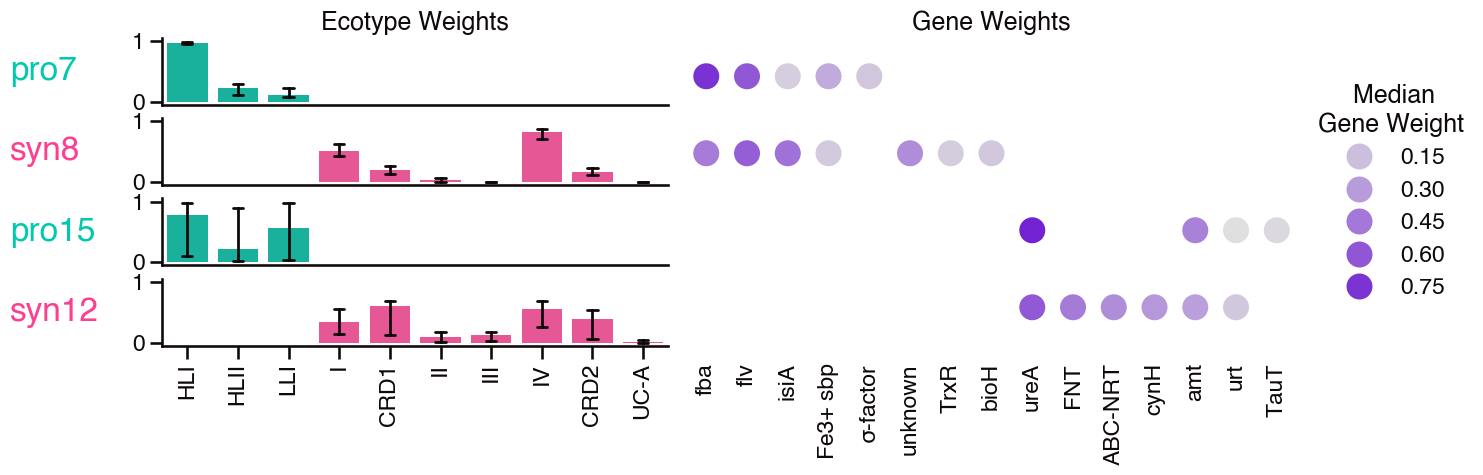

In [17]:
# make ecotype & gene weight figure

# set up figure
sample_weight_range = (-0.05, 1.05) # range of weights to show on sample plots
fig = plt.figure(figsize=(16, 4))
rows = 4
cols = 12
grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)

# plot taxon weights
clusters = [f"pro{fe_clusters['pro']}", f"syn{fe_clusters['syn']}", f"pro{n_clusters['pro']}", f"syn{n_clusters['syn']}"]
for i, cid in enumerate(clusters):
    axis = plt.subplot(grid[i, 1:6])
    plot_df = ecotype_df[ecotype_df['Cluster'] == cid]
    sns.barplot(
        data=plot_df, x='Clade', y='TaxonWeight', hue='Genus', order=clade_labels, hue_order=['Prochlorococcus', 'Synechococcus'], 
        palette=[sns.color_palette()[i] for i in [2, 3]], estimator='median', errorbar=('pi', 90), 
        capsize=.2, err_kws={'linewidth': 2, 'c': line_color}, legend=False, ax=axis
    )
    # labels and such
    axis.annotate(cid, xy=(-0.3, 0.5), xycoords='axes fraction', va='center', ha='left', fontsize=24, annotation_clip=False, 
                  color=sns.color_palette()[{'Prochlorococcus': 2, 'Synechococcus': 3}[plot_df.Genus.unique()[0]]])
    axis.set(title=('Ecotype Weights' if not i else None), ylim=sample_weight_range, xlabel=None, ylabel=None)
    if i != 3:
        axis.tick_params(bottom=False, labelbottom=False)
    else:
        axis.set_xticks(clade_labels, clade_labels, rotation=90)

# plot gene weights
axis = plt.subplot(grid[:4, 6:])
axis.spines[['left', 'bottom']].set_visible(False)
plot_df = median_gene_df[median_gene_df.Ortholog.isin(gene_labels.keys())]
with pd.option_context('mode.chained_assignment', None):
    plot_df['x'] = plot_df.Ortholog.map(dict(zip(gene_labels.keys(), np.arange(len(gene_labels)))))
    plot_df['y'] = plot_df.Cluster.map(dict(zip(clusters, reversed(np.arange(len(clusters))))))
sns.scatterplot(
    x='x', 
    y='y', 
    hue='GeneWeight', 
    # size='GeneWeight', 
    # sizes=(30, 300), 
    s=300, 
    edgecolor=None, 
    palette=bi_cmap, 
    data=plot_df, 
    legend=True,
    ax=axis
);
axis.set(title='Gene Weights', xlabel=None, ylabel=None, xlim=(-0.5, len(gene_labels)-0.5), ylim=(-0.5, 3.5))
axis.set_xticks(np.arange(len(gene_labels)), gene_labels.values(), rotation=90)
axis.tick_params(left=False, labelleft=False, bottom=False)
axis.legend(title='     Median\nGene Weight', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


# generate figure
### combined figure

In [18]:
# set up incubation weights with both Fe and nitrogen clusters

# set up data
treatments = ['control 0h', 'control 96h', 'low Fe', 'high Fe', 'Fe', 'N+P+Fe', 'N+P', 'low N+P', 'high N+P']
with pd.option_context('mode.chained_assignment', None):
    fe_incubation_df = fe_cluster_df[fe_cluster_df.Treatment.isin(treatments)]
    fe_incubation_df['ClusterGroup'] = 'Fe'
    n_incubation_df = n_cluster_df[n_cluster_df.Treatment.isin(treatments)]
    n_incubation_df['ClusterGroup'] = 'N'
incubation_df = pd.concat([fe_incubation_df, n_incubation_df]).reset_index(drop=True).fillna(0)
incubation_df = incubation_df.sort_values('Treatment', key=lambda s: s.apply(treatments.index))
incubation_df['Condition'] = incubation_df['Condition'].map({'gyre': 'Gyre', 'TZ': 'TZ', 'HNLC': 'HNLC'})

incubation_df


,Bootstrap,Replicate,SampleName,SampleWeight,Genus,Cruise,Year,Datetime,Latitude,Longitude,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Experiment,Condition,Treatment,Timepoint,ClusterGroup
8699,99,C,G2.SURF.NS.S16C1.15m,0.000000,Synechococcus,Gradients 2,2017,2017-06-09 16:37:00,32.928833,-158.000333,15,Gradients 2 surface,surface transect,0.69,6pm,REXP3 T0 Ctrl,Gyre,control 0h,0h,Fe
7469,72,B,G2.SURF.NS.S16C1.15m,0.000000,Synechococcus,Gradients 2,2017,2017-06-09 16:37:00,32.928833,-158.000333,15,Gradients 2 surface,surface transect,0.69,6pm,REXP3 T0 Ctrl,Gyre,control 0h,0h,Fe
7460,72,B,G2.REXP2.NS.Ctrl.T0,0.467642,Synechococcus,Gradients 2,2017,2017-06-06 12:00:00,36.999822,-157.999689,15,Resource ratio incubation,surface transect,0.50,2pm,REXP2 T0,TZ,control 0h,0h,Fe
7455,72,B,G2.REXP1.NS.Ctrl.T0,0.114110,Synechococcus,Gradients 2,2017,2017-06-03 12:00:00,41.416838,-157.999704,15,Resource ratio incubation,surface transect,0.50,2pm,REXP1 T0,HNLC,control 0h,0h,Fe
7454,72,A,G2.SURF.NS.S16C1.15m,0.000000,Synechococcus,Gradients 2,2017,2017-06-09 16:37:00,32.928833,-158.000333,15,Gradients 2 surface,surface transect,0.69,6pm,REXP3 T0 Ctrl,Gyre,control 0h,0h,Fe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8516,95,C,G2.REXP3.NS.HiNP.T96,0.000000,Synechococcus,Gradients 2,2017,2017-06-13 15:00:00,33.000000,-158.000000,15,Resource ratio incubation,incubations,0.63,2pm,REXP3 T96 HiNP,Gyre,high N+P,96h,Fe
15686,61,C,G2.REXP3.NS.HiNP.T96,0.000000,Synechococcus,Gradients 2,2017,2017-06-13 15:00:00,33.000000,-158.000000,15,Resource ratio incubation,incubations,0.63,2pm,REXP3 T96 HiNP,Gyre,high N+P,96h,N
8531,96,A,G2.REXP3.NS.HiNP.T96,0.000000,Synechococcus,Gradients 2,2017,2017-06-13 15:00:00,33.000000,-158.000000,15,Resource ratio incubation,incubations,0.63,2pm,REXP3 T96 HiNP,Gyre,high N+P,96h,Fe
8426,93,C,G2.REXP3.NS.HiNP.T96,0.000000,Synechococcus,Gradients 2,2017,2017-06-13 15:00:00,33.000000,-158.000000,15,Resource ratio incubation,incubations,0.63,2pm,REXP3 T96 HiNP,Gyre,high N+P,96h,Fe


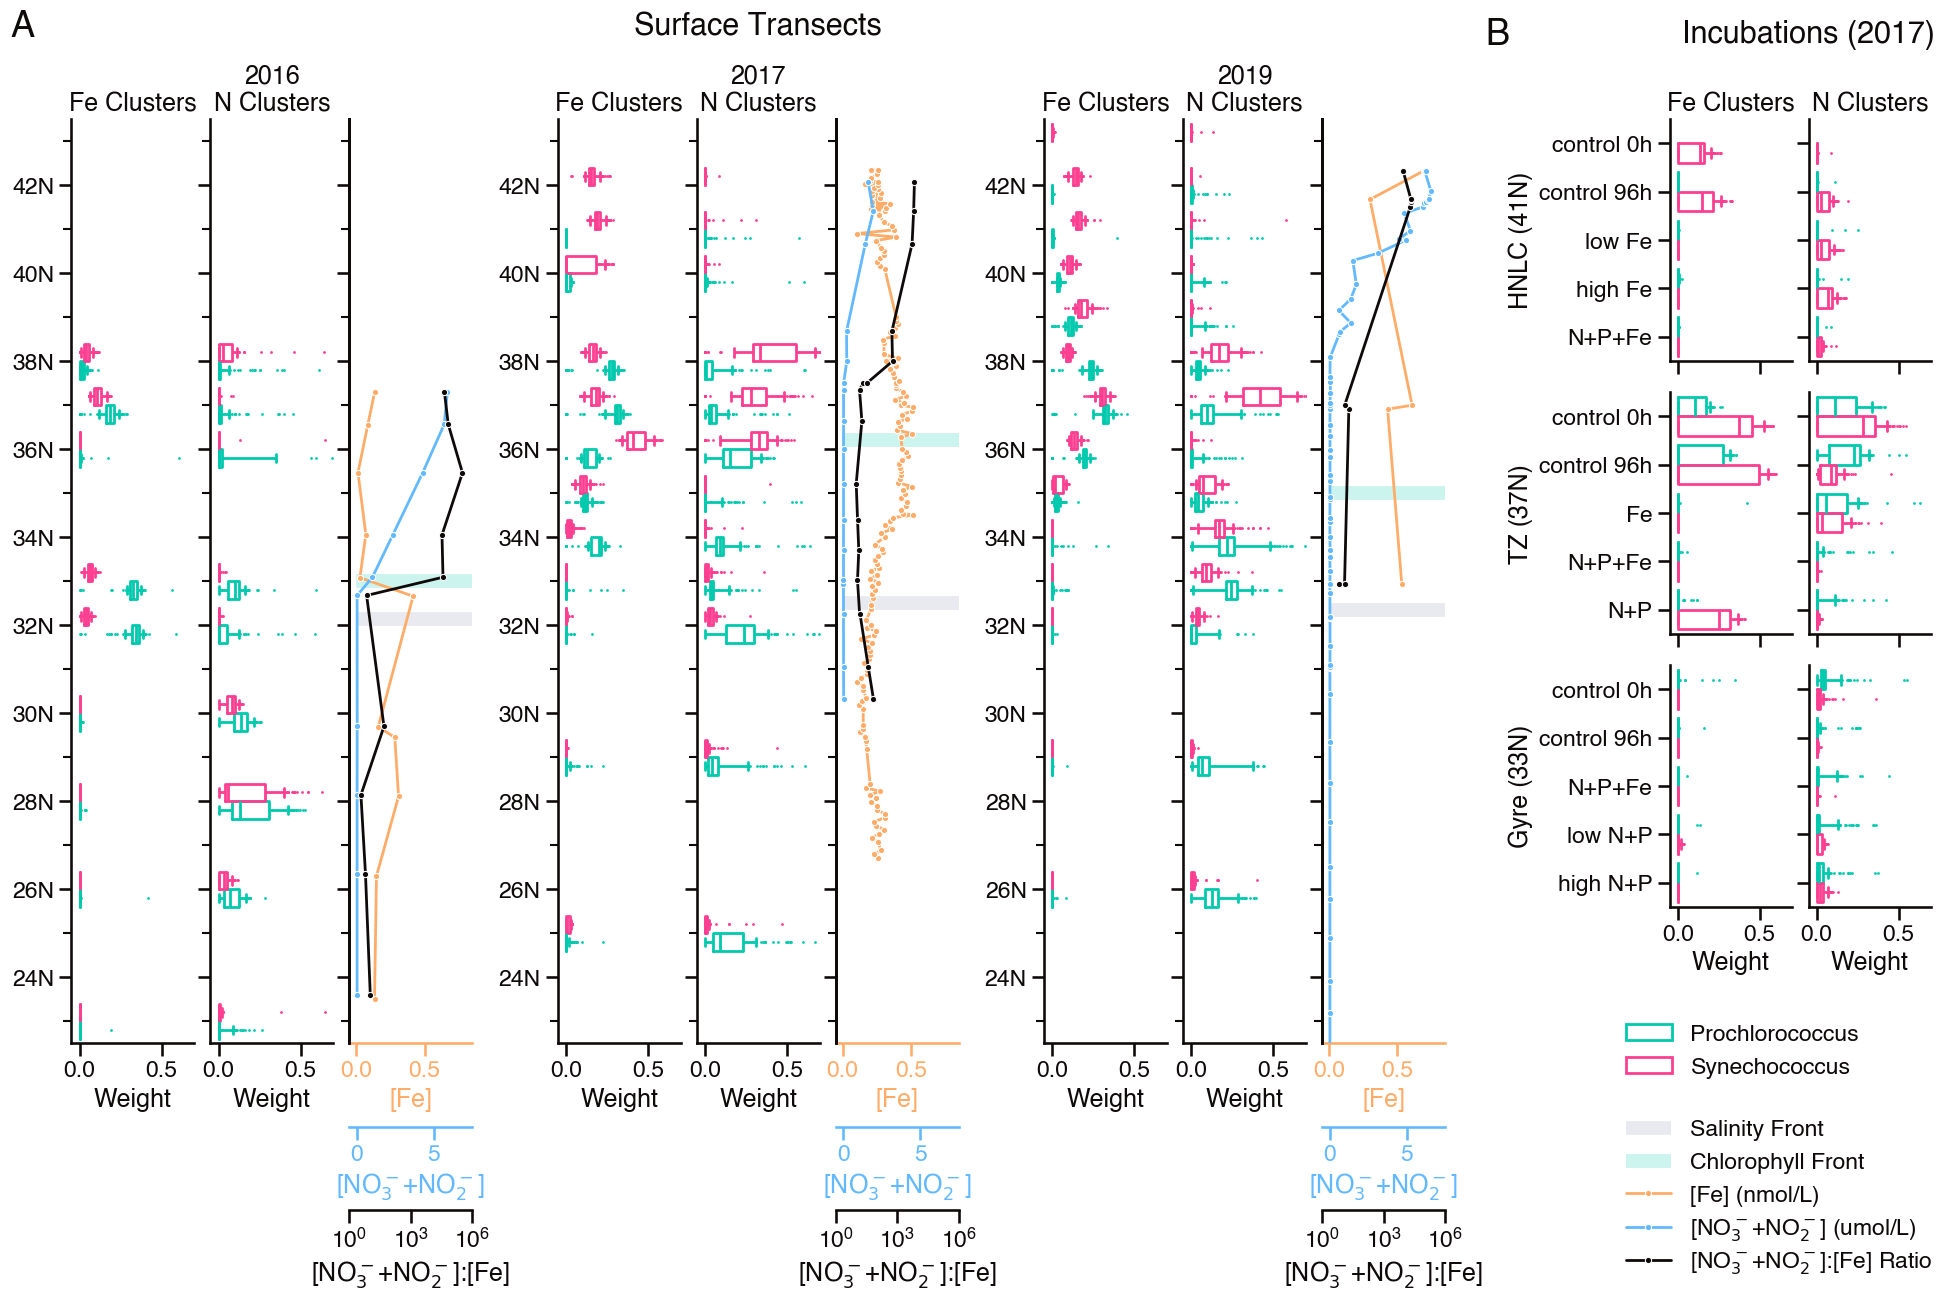

In [20]:
# build combined fe & n cluster figure

# set up figure
sample_weight_range = (-0.05, 0.7) # range of weights to show on sample plots
fig = plt.figure(figsize=(24, 12))
rows = 7
cols = 27
grid = plt.GridSpec(rows, cols, hspace=.3, wspace=.3)
n_bins = 21
bounds = (23, 43)
depth_limit = 15 # meters
# time_classes = ['2am', '6am', '10am']
time_classes = ['2am', '6am', '10am', '2pm', '6pm', '10pm']
fliersize = 1
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 26, 'annotation_clip': False
}

# panel a: surface transects + environmental covariates
for i, year in enumerate([2016, 2017, 2019]):
    # Fe limitation cluster
    axis = plt.subplot(grid[:, 7*i:7*i+2])
    # add annotation
    if i == 0:
        axis.annotate('A', xy=(-0.5, 1.1), **annot_kwgs)
    # get data together
    plot_df = fe_cluster_df[fe_cluster_df['SampleGroup'] == 'surface transect']
    plot_df = plot_df[plot_df['TimeClass'].isin(time_classes)]
    plot_df = plot_df[plot_df['Year'] == year]
    latitudes = plot_df[
        ['SampleName', 'Latitude']].drop_duplicates().set_index('SampleName').sort_values('Latitude')['Latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=False)
    plot_df['lat_idx'] = plot_df['SampleName'].map(dict(zip(latitudes.index, lat_bins)))
    # make figure
    sns.boxplot(
        data=plot_df, x='SampleWeight', y='lat_idx', hue='Genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
        palette=[sns.color_palette()[i] for i in [2, 3]], orient='y', order=np.arange(n_bins), 
        fill=False, whis=(5, 95), fliersize=fliersize, legend=False, ax=axis
    )
    # set labels and such
    axis.set_yticks(np.arange(1, n_bins, 2), [f'{int(l)}N' for l in np.arange(bounds[0]+1, bounds[1]+1, 2)])
    axis.set(xlim=sample_weight_range, ylim=(-0.5, n_bins-0.5), xlabel='Weight', ylabel='', title='Fe Clusters')
    axis.set_yticks(np.arange(n_bins), minor=True)
    
    # N acquisition cluster
    axis = plt.subplot(grid[:, 7*i+2:7*i+4])
    # add title
    if i == 1:
        axis.annotate('Surface Transects', xy=(.5, 1.1), xycoords='axes fraction', va='center', ha='center', fontsize=22)
    # get data together
    plot_df = n_cluster_df[n_cluster_df['SampleGroup'] == 'surface transect']
    plot_df = plot_df[plot_df['TimeClass'].isin(time_classes)]
    plot_df = plot_df[plot_df['Year'] == year]
    plot_df['lat_idx'] = plot_df['SampleName'].map(dict(zip(latitudes.index, lat_bins)))
    # make figure
    sns.boxplot(
        data=plot_df, x='SampleWeight', y='lat_idx', hue='Genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
        palette=[sns.color_palette()[i] for i in [2, 3]], orient='y', order=np.arange(n_bins), fill=False, 
        whis=(5, 95), fliersize=fliersize, legend=False, ax=axis
    )
    # set labels and such
    axis.set_yticks(np.arange(1, n_bins, 2))
    axis.set(xlim=sample_weight_range, ylim=(-0.5, n_bins-0.5), xlabel='Weight', ylabel='', title=f"{year}\nN Clusters")
    axis.set_yticks(np.arange(n_bins), minor=True)
    axis.tick_params(left=True, labelleft=False)

    # environmental covariates
    axis = plt.subplot(grid[:, 7*i+4:7*i+6])
    # plot salinity front
    axis.hlines(y=sal_fronts[year], xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[5], alpha=0.2, label='Salinity Front')
    # plot chlorophyll front
    axis.hlines(y=chl_fronts[year], xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[2], alpha=0.2, label='Chlorophyll Front')
    
    # dissolved iron
    color = sns.color_palette()[1]
    sns.lineplot(
        data=fe_df[(fe_df['year'] == year) & (fe_df['depth'].le(depth_limit))], x='Fe_dissolved', 
        y='lat', orient='y', ax=axis, color=color, marker='.', label='[Fe] (nmol/L)', legend=(i==2)
    )
    axis.set(xlim=(-.05, 0.85), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.arange(1, n_bins, 2)+bounds[0], 
             xlabel='[Fe]', ylabel='')
    axis.set_yticks(np.arange(n_bins)+bounds[0], minor=True)
    axis.tick_params(left=True, labelleft=False)
    axis.tick_params(axis='x', colors=color)
    axis.xaxis.label.set_color(color)
    axis.spines['bottom'].set_color(color)
    if i == 2:
        axis.legend(loc='upper left', bbox_to_anchor=(2.3, -0.06))

    # dissolved nitrate + nitrite
    color = sns.color_palette()[7]
    axis2 = plt.twiny(axis)
    sns.lineplot(
        data=n_df[(n_df['year'] == year) & (n_df['depth'].le(depth_limit))], x='NO3_NO2', y='lat', orient='y', 
        ax=axis2, color=color, marker='.', label='[NO$_3^-$+NO$_2^-$] (umol/L)', legend=(i==2)
    )
    axis2.set(xlim=(-0.5, 7.5), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.arange(1, n_bins, 2)+bounds[0], 
             xlabel='[NO$_3^-$+NO$_2^-$]', ylabel='')
    axis2.set_yticks(np.arange(n_bins)+bounds[0], minor=True)
    axis2.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    axis2.tick_params(axis='x', colors=color)
    axis2.xaxis.set_label_position('bottom')
    axis2.xaxis.label.set_color(color)
    axis2.spines['bottom'].set_color(color)
    axis2.spines['bottom'].set_position(('outward', 60))
    if i == 2:
        axis2.legend(loc='upper left', bbox_to_anchor=(2.3, -0.165))

    # N:Fe ratio
    color = sns.color_palette()[4]
    axis3 = plt.twiny(axis2)
    sns.lineplot(
        data=merged_df[(merged_df['year'] == year) & (merged_df['depth'].le(depth_limit))], x='N:Fe', y='lat', orient='y', 
        ax=axis3, color=color, marker='.', label='[NO$_3^-$+NO$_2^-$]:[Fe] Ratio', legend=(i==2)
    )
    axis3.set(xlim=(1, 1000000), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.arange(1, n_bins, 2)+bounds[0], 
             xlabel='[NO$_3^-$+NO$_2^-$]:[Fe]', ylabel='', xscale='log')
    axis3.set_yticks(np.arange(n_bins)+bounds[0], minor=True)
    axis3.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    axis3.tick_params(axis='x', colors=color)
    axis3.xaxis.set_label_position('bottom')
    axis3.xaxis.label.set_color(color)
    axis3.spines['bottom'].set_color(color)
    axis3.spines['bottom'].set_position(('outward', 120))
    if i == 2:
        axis3.legend(loc='upper left', bbox_to_anchor=(2.3, -0.2))

# panel b: incubation weights
for i, condition in enumerate(['HNLC', 'TZ', 'Gyre']):
    for j, clustergroup in enumerate(['Fe', 'N']):
        axis = plt.subplot(grid[i*2:i*2+2, 23+(2*j):25+(2*j)])
        plot_df = incubation_df[(incubation_df['Condition'] == condition) & (incubation_df['ClusterGroup'] == clustergroup)]
        sns.boxplot(
            data=plot_df, x='SampleWeight', y='Treatment', hue='Genus', 
            hue_order=['Prochlorococcus', 'Synechococcus'], palette=[sns.color_palette()[i] for i in [2, 3]], 
            orient='y', fill=False, whis=(5, 95), fliersize=fliersize, legend=(i==2 and j==0), ax=axis
        )
        # labels and such
        if i == 0:
            axis.set(title='{} Clusters'.format(clustergroup))
            if j == 0:
                axis.annotate('B', xy=(-1.5, 1.35), **annot_kwgs)
            if j == 1:
                axis.annotate('Incubations (2017)', xy=(0, 1.35), xycoords='axes fraction', va='center', ha='center', fontsize=22)
        if i == 2:
            xlabel = 'Weight'
            if j == 0:
                axis.legend(loc='upper left', bbox_to_anchor=(-0.52, -0.4))
        else:
            xlabel = None
        if j == 0:
            ylabel = f"{condition} ({plot_df.Latitude.mean():.0f}N)"
        else:
            ylabel = None
        axis.set(xlim=sample_weight_range, xlabel=xlabel, ylabel=ylabel)
        axis.tick_params(left=True, labelleft=(j==0), bottom=True, labelbottom=(i==2))

fig.savefig(outdir / 'fe-n-clusters.png', bbox_inches='tight')
